In [1]:
##############################################################
#  WARNING, EXECUTE THIS LINE BEFORE EXECUTING ANY ROS CODE  #
#                                                            #
#             source opt/ros/foxy/setup.bash                 #
#                                                            #
##############################################################

In [2]:
#                                IMPORTING ALL THE LIBRARIES I NEED

from __future__ import absolute_import, division, print_function# need to undestend their utility <-------- UNKNOWN
import tensorflow as tf
import keras# dont import keras ftom tensorflow library otherwise the code below will fail
from sklearn.model_selection import train_test_split
import numpy as np
from keras_visualizer import visualizer# used to visualize the neural network <-------------------- MORE INFORMATION
from tensorflow.keras.utils import plot_model# used to plot the neural network model <------------------MORE INFO
import matplotlib.pyplot as plt# this library will be used for data visualization
import networkx as nx# library for network creation/visualization/manipulation
np.random.seed(0)

try:
    import tqdm# import trange# used for progress bar visualization
except:
    print("\n\n ATTENZIONE, TI MANCA LA LIBRERIA tqdm PER LA VISUALIZZAZIONE DEL \
    PROGRESSO NEI CICLI FOR. PER INSTALLARLA DIGITA 'sudo pip3 install tqdm'")

TestSize = 0.1# size of the test set

percent = 0.8# percentage of data we want to give to our system from all the data aveilable
# we start to take them from the start of the dataset , one after one)

LukyNumber = 4# the number that in this session will be associated to 1 while the others will be set to 0
# (we set all the other numbers to zero becouse otherwise the neural network behave incorrectly with thos libraries)


2022-07-03 16:43:56.129905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-03 16:43:56.129949: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#                                  Generate Network Bynomial Graph

NN = 7
I_NN = np.identity(NN, dtype=int)# identity matrix ?
p_ER = 0.3# probability that that node is connected to another node
while 1:
    Adj = np.random.binomial(1, p_ER, (NN,NN))# create a NN x NN matrix with random connections
    Adj = np.logical_or(Adj,Adj.T)# <-------------------------------------------------------------------------- ???
    Adj = np.multiply(Adj,np.logical_not(I_NN)).astype(int)# <------------------------------------------------- ???

    test = np.linalg.matrix_power((I_NN+Adj),NN)# <------------------------------------------------- ???
    
    if np.all(test>0):# here he tests if the matrix that he created is connected
        print("Congratulation, the graph is connected.")
        break 
    else:
        print("Warning, the graph is NOT connected.")
        quit()

Congratulation, the graph is connected.


In [4]:
#                                       Compute mixing matrices
#                     Metropolis-Hastings method to obtain a doubly-stochastic matrix

WW = np.zeros((NN,NN))

for ii in range(NN):
    N_ii = np.nonzero(Adj[ii])[0] # In-Neighbors of node i
    deg_ii = len(N_ii)

    for jj in N_ii:
        N_jj = np.nonzero(Adj[jj])[0] # In-Neighbors of node j
        # deg_jj = len(N_jj)
        deg_jj = N_jj.shape[0]

        WW[ii,jj] = 1/(1+max( [deg_ii,deg_jj] ))
        # WW[ii,jj] = 1/(1+np.max(np.stack((deg_ii,deg_jj)) ))

WW += I_NN - np.diag(np.sum(WW,axis=0))
    
with np.printoptions(precision=4, suppress=True):
    print('Check Stochasticity\n row:    {} \n column: {}'.format(
      np.sum(WW,axis=1),
        np.sum(WW,axis=0)
    ))

Check Stochasticity
 row:    [1. 1. 1. 1. 1. 1. 1.] 
 column: [1. 1. 1. 1. 1. 1. 1.]


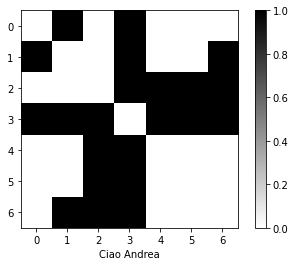

In [5]:
#                        I want to see how the Adjacency matrix look like

plt.imshow(Adj, cmap=plt.cm.binary)
plt.xlabel("Ciao Andrea")
plt.colorbar()
plt.show()

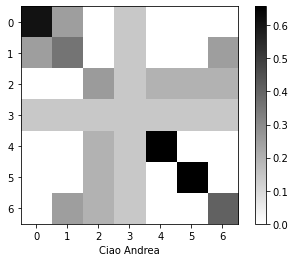

In [6]:
#                     I want to see how the weighted Adjacency matrix look like

plt.imshow(WW, cmap=plt.cm.binary)
plt.xlabel("Ciao Andrea")
plt.colorbar()
plt.show()

/tmp/ipykernel_3361/2349113121.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


A =  [[0 1 0 1 0 0 0]
 [1 0 0 1 0 0 1]
 [0 0 0 1 1 1 1]
 [1 1 1 0 1 1 1]
 [0 0 1 1 0 0 0]
 [0 0 1 1 0 0 0]
 [0 1 1 1 0 0 0]]


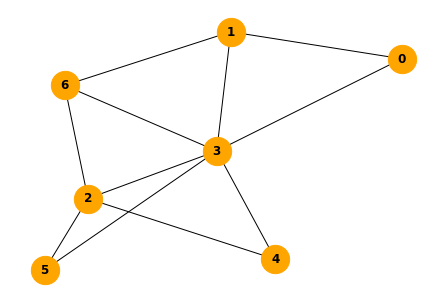

In [7]:
#                                Drowing of the graph

G = nx.Graph()# initialization of the object 
#G.add_node(0)
G.add_nodes_from([x for x in range(NN)])# creation of the nodes list
#G.add_edge(0, 3)
ListEdges = []
for i in range(NN):
    for j in range(NN):
        if Adj[i][j] == 1:
            ListEdges.append((i, j))
            
G.add_edges_from(ListEdges)

A = nx.adjacency_matrix(G)
print('A = ',A.toarray())

nx.draw(G, with_labels=True, font_weight='bold', node_color= 'orange', node_size= 800)

In [8]:
#                              Data acquisition and processing
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# import the dataset "mnist" that contains all the images of the numbers
# and relatives lables an then assine all those data to two sets ( training set and test set )

# adjusting the type of the data contained in the arrays in this way they can be also negative( maybe now it is usless)
y_train = y_train.astype(np.int8)
y_test = y_test.astype(np.int8)

# i have to scale the brightness of each pixel becouse otherwise i saturate the activation function
#(a wise man told me)
x_train = x_train/255
x_test = x_test/255

In [9]:
#               I want to see some information about my data and they format

print(type(x_train))# return the typology of our data set of images
print(len(x_train))# retunr the lenth of the data set ( how much images we have )
print(np.shape(x_train))# return the shape of the data set, in our case we have the
# lenth and then the dimensions of the images

print(type(x_test))# return the typology of our training set of images
print(len(x_test))# retunr the lenth of the training set ( how much images we have )
print(np.shape(x_test))# return the shape of the training set, in our case we have the
# lenth and then the dimensions of the images

#print(dir(np))
#print(help(np.concatenate))

<class 'numpy.ndarray'>
60000
(60000, 28, 28)
<class 'numpy.ndarray'>
10000
(10000, 28, 28)


In [10]:
#                           Merging of training set and data set

x_total_temp = np.append(x_train, x_test, axis=0)# CHECK IF THE PARTS ARE APPENDED CORRECTLY <------------- WARNING
print("Shape of x_total_temp: {0}".format(np.shape(x_total_temp)))

x_total = x_total_temp[0: int(np.shape(x_total_temp)[0]*percent)]
print("Shape of x_total reduced to {1}: {0}".format(np.shape(x_total), percent))

y_total_temp = np.append(y_train, y_test, axis=0)# CHECK IF THE PARTS ARE APPENDED CORRECTLY <------------- WARNING
print("Shape of y_total_temp: {0}".format(np.shape(y_total_temp)))

y_total = y_total_temp[0: int(np.shape(y_total_temp)[0]*percent)]
print("Shape of y_total reduced to {1}: {0}".format(np.shape(y_total), percent))

Shape of x_total_temp: (70000, 28, 28)
Shape of x_total reduced to 0.8: (56000, 28, 28)
Shape of y_total_temp: (70000,)
Shape of y_total reduced to 0.8: (56000,)


In [11]:
#                Random redistribution of the data in two sets ( test and train)

x_train, x_test, y_train, y_test = train_test_split(x_total, y_total, test_size=TestSize)

In [12]:
#                      Reassignment of the labels according to the requirements [1, -1]

# REWRITE THE CODE BECAUSE IT ISNT EFFISCENT ENOUGH (nested for loops or something else)

for i in range(0, np.shape(y_train)[0]):# <-------------------------------------------------- WARNING (use iterator)
    if y_train[i] == LukyNumber:
        y_train[i] = 1
    else:
        y_train[i] = -1
        
for i in range(0, np.shape(y_test)[0]):# <-------------------------------------------------- WARNING (use iterator)
    if y_test[i] == LukyNumber:
        y_test[i] = 1
    else:
        y_test[i] = -1
#print(y_test.dtype)

In [13]:
#                               TEST TO SEE THE SHAPE OF THE DATA

print("Lenth of y_train : {}\n".format(len(y_train)))
print("Shape of y_train : {}\n".format(np.shape(y_train)))
print("y_training : {}\n".format(y_train))

print("Lenth of y_test : {}\n".format(len(y_test)))
print("Shape of y_test : {}\n".format(np.shape(y_test)))
print("y_test : {}\n".format(y_test))

#                               I WANT TO SEE THE SHAPE OF PICTURES

print("Lenth of x_train : {}\n".format(len(x_train)))
print("Shape of x_train : {}\n".format(np.shape(x_train)))
print("x_train : {}\n".format(x_train))

print("Lenth of x_test : {}\n".format(len(x_test)))
print("Shape of x_test : {}\n".format(np.shape(x_test)))
print("x_test : {}\n".format(x_test))

Lenth of y_train : 50400

Shape of y_train : (50400,)

y_training : [-1 -1 -1 ... -1 -1 -1]

Lenth of y_test : 5600

Shape of y_test : (5600,)

y_test : [-1  1 -1 ... -1 -1 -1]

Lenth of x_train : 50400

Shape of x_train : (50400, 28, 28)

x_train : [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0

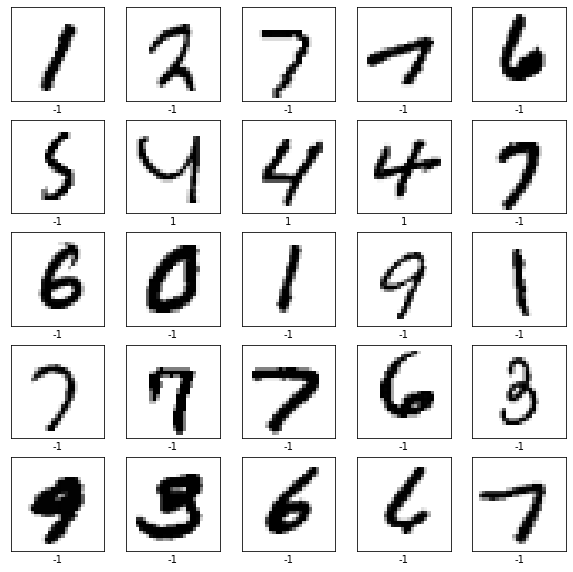

In [14]:
# display the first 25 training images with labels and verify that the data is in the correct formate.

plt.figure(figsize=(10,10))# <--------------------------------------------------------------------------- UNKNOWN
for i in range(25):# i want to plot 25 images
    plt.subplot(5,5,i+1)# the letter "i" rappresent the position 
    plt.xticks([])# <------------------------------------------------------------------------------------ UNKNOWN
    plt.yticks([])
    plt.grid(False)# in this way i will not have the grid in on the images
    plt.imshow(x_train[i], cmap=plt.cm.binary)# load the image and make it show black and white
    plt.xlabel(y_train[i])# add the lable associated to that image under it
plt.show()# show all the images

In [15]:
# HERE I RESHAPE THE IMAGES FROM A MATRIX TO A VECTOR MANTAINING THE DATA CONTENT

SrecchedDatasetX = np.reshape(x_train, (np.shape(x_train)[0], 784))# the dataset has 11200 elements, you have to make this part of code more general

# TEST TO SEE THE SHAPE OF THE DATA
print("Lenth of y_training : {}\n".format(len(y_train)))
print("Shape of y_training : {}\n".format(np.shape(y_train)))
print("y_training : {}\n".format(y_train))

# I WANT TO SEE THE SHAPE OF PICTURES
print("Lenth of x_training : {}\n".format(len(SrecchedDatasetX)))
print("Shape of x_training : {}\n".format(np.shape(SrecchedDatasetX)))
print("x_training : {}\n".format(SrecchedDatasetX))

Lenth of y_training : 50400

Shape of y_training : (50400,)

y_training : [-1 -1 -1 ... -1 -1 -1]

Lenth of x_training : 50400

Shape of x_training : (50400, 784)

x_training : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]



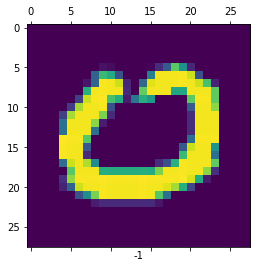

In [16]:
# HERE I TEST THE CONVERSION GOING BACKWARD (CHEKING IF THE IMAGE IS CORRECT)
#print(SrecchedDatasetX[1])
mm = 300
prova = np.reshape(SrecchedDatasetX[mm], (28, 28))# here at index you can put whatewer number you wish to see if the conversion went correctly
plt.matshow(prova)
plt.xlabel(y_train[mm])
plt.show()

In [17]:
ZeroVector = np.zeros(784+1)# vector of zeros which will be used in the future

In [18]:
# function that returns the average of a sequence of numbers
def moving_average(a, n=64) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [19]:
# here i will redistribute the data in equal sets from lable point of wiew

print("Shape of y_training : {}\n".format(np.shape(y_train)))
print("Shape of SrecchedDatasetX : {}\n".format(np.shape(SrecchedDatasetX)))

print("Shape of y_testing (not converted): {}\n".format(np.shape(y_test)))# these can be overlooked
print("Shape of x_testing (not converted): {}\n".format(np.shape(x_test)))# these can be overlooked

LenthOfArray = 1000# half length of the array containing the vectorized images
BalancedArray = np.zeros([2*LenthOfArray, 784])# vector containing vectorized images
BalancedLable = np.zeros([2*LenthOfArray])# cevtor containing lables
OnesVector = np.zeros([LenthOfArray, 784])# vector containing vectorized images with lable = 1
OnesLable = np.ones([LenthOfArray])# vector containing lables = 1
NegativeOnesVector = np.zeros([LenthOfArray, 784])# vector containing vectorized images with lable = -1
NegativeOnesLable = -np.ones([LenthOfArray])# vector containing lables = -1

LenthOfArrayPlus = LenthOfArray-1# it is a counter for while cycle (used for positions in the final array)
LenthOfArrayMinus = LenthOfArray-1# it is a counter for while cycle (used for positions in the final array)

CounterPlus = 0# it is a counter for while cycle (used for positions in the old array)
CounterMinus = 0# it is a counter for while cycle (used for positions in the old array)

while LenthOfArrayPlus>-1:
    if (y_train[CounterPlus] == 1):
        #print("ciao1 {}\n".format(LenthOfArrayPlus))
        OnesVector[LenthOfArrayPlus] = SrecchedDatasetX[CounterPlus]
        LenthOfArrayPlus = LenthOfArrayPlus - 1
    CounterPlus = CounterPlus + 1
        
while LenthOfArrayMinus>-1:
    if (y_train[CounterMinus] == -1):
        #print("ciao-1 {}\n".format(LenthOfArrayMinus))
        NegativeOnesVector[LenthOfArrayMinus] = SrecchedDatasetX[CounterMinus]
        LenthOfArrayMinus = LenthOfArrayMinus - 1
    CounterMinus = CounterMinus + 1

# positive
for i in range(0, LenthOfArray):
    #print(2*i)
    BalancedArray[2*i] = OnesVector[i]
    BalancedLable[2*i] = OnesLable[i]

# negative
for i in range(0, LenthOfArray):
    #print(2*i-1)
    BalancedArray[2*i-1] = NegativeOnesVector[i]
    BalancedLable[2*i-1] = NegativeOnesLable[i]    

print("\ndone\n")

Shape of y_training : (50400,)

Shape of SrecchedDatasetX : (50400, 784)

Shape of y_testing (not converted): (5600,)

Shape of x_testing (not converted): (5600, 28, 28)


done



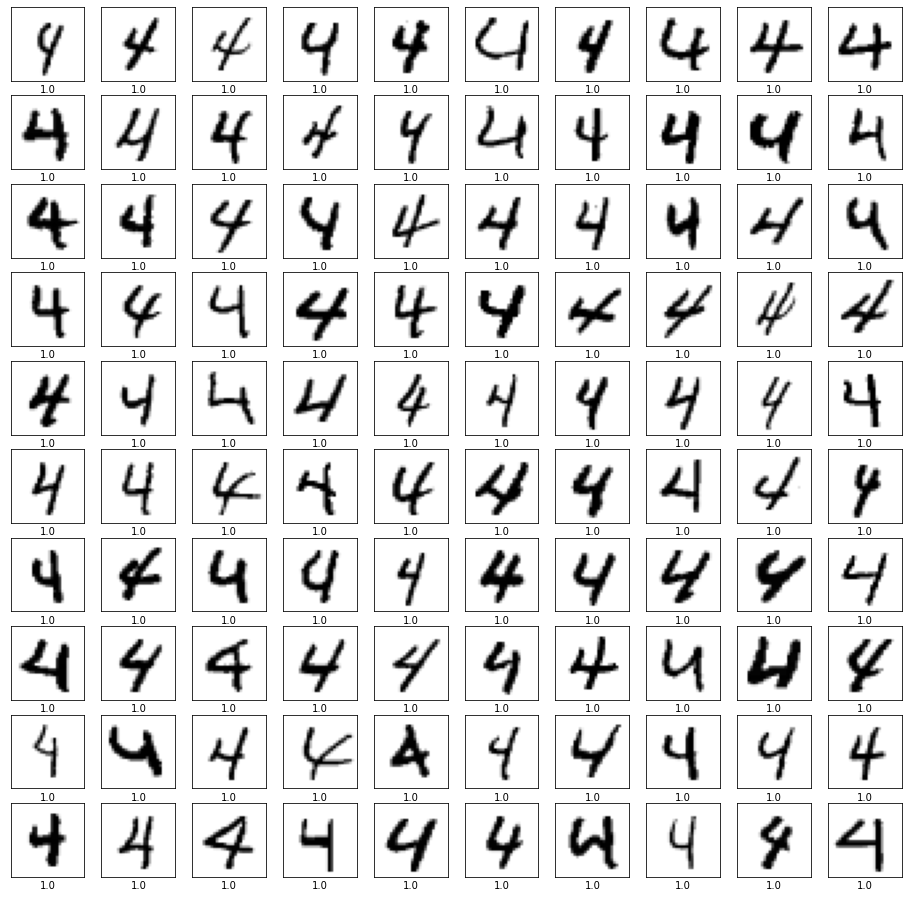

In [20]:
# display the first 100 training images with labels and verify that the data is in the correct formate.

plt.figure(figsize=(16,16))# <--------------------------------------------------------------------------- UNKNOWN
for i in range(100):# i want to plot 25 images
    plt.subplot(10,10,i+1)# the letter "i" rappresent the position 
    plt.xticks([])# <------------------------------------------------------------------------------------ UNKNOWN
    plt.yticks([])
    plt.grid(False)# in this way i will not have the grid in on the images
    plt.imshow(np.reshape(OnesVector[i], (28, 28)), cmap=plt.cm.binary)# load the image and make it show black and white
    plt.xlabel(OnesLable[i])# add the lable associated to that image under it
plt.show()# show all the images

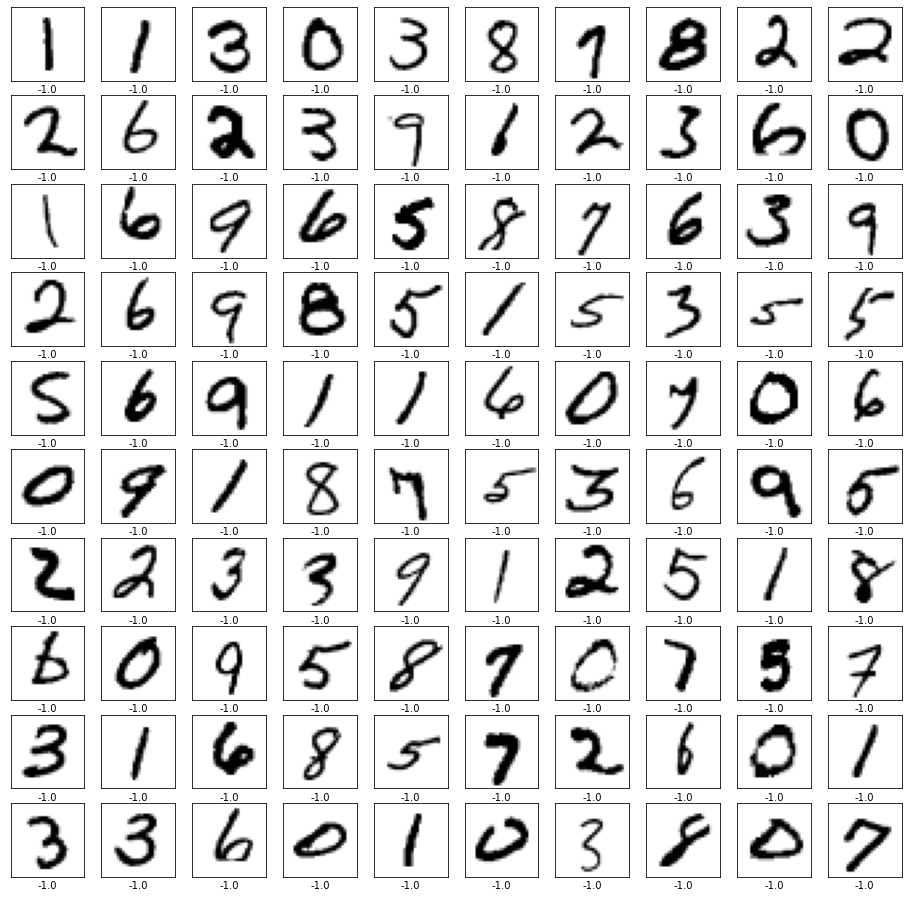

In [21]:
# display the first 100 training images with labels and verify that the data is in the correct formate.

plt.figure(figsize=(16,16))# <--------------------------------------------------------------------------- UNKNOWN
for i in range(100):# i want to plot 25 images
    plt.subplot(10,10,i+1)# the letter "i" rappresent the position 
    plt.xticks([])# <------------------------------------------------------------------------------------ UNKNOWN
    plt.yticks([])
    plt.grid(False)# in this way i will not have the grid in on the images
    plt.imshow(np.reshape(NegativeOnesVector[i], (28, 28)), cmap=plt.cm.binary)# load the image and make it show black and white
    plt.xlabel(NegativeOnesLable[i])# add the lable associated to that image under it
plt.show()# show all the images

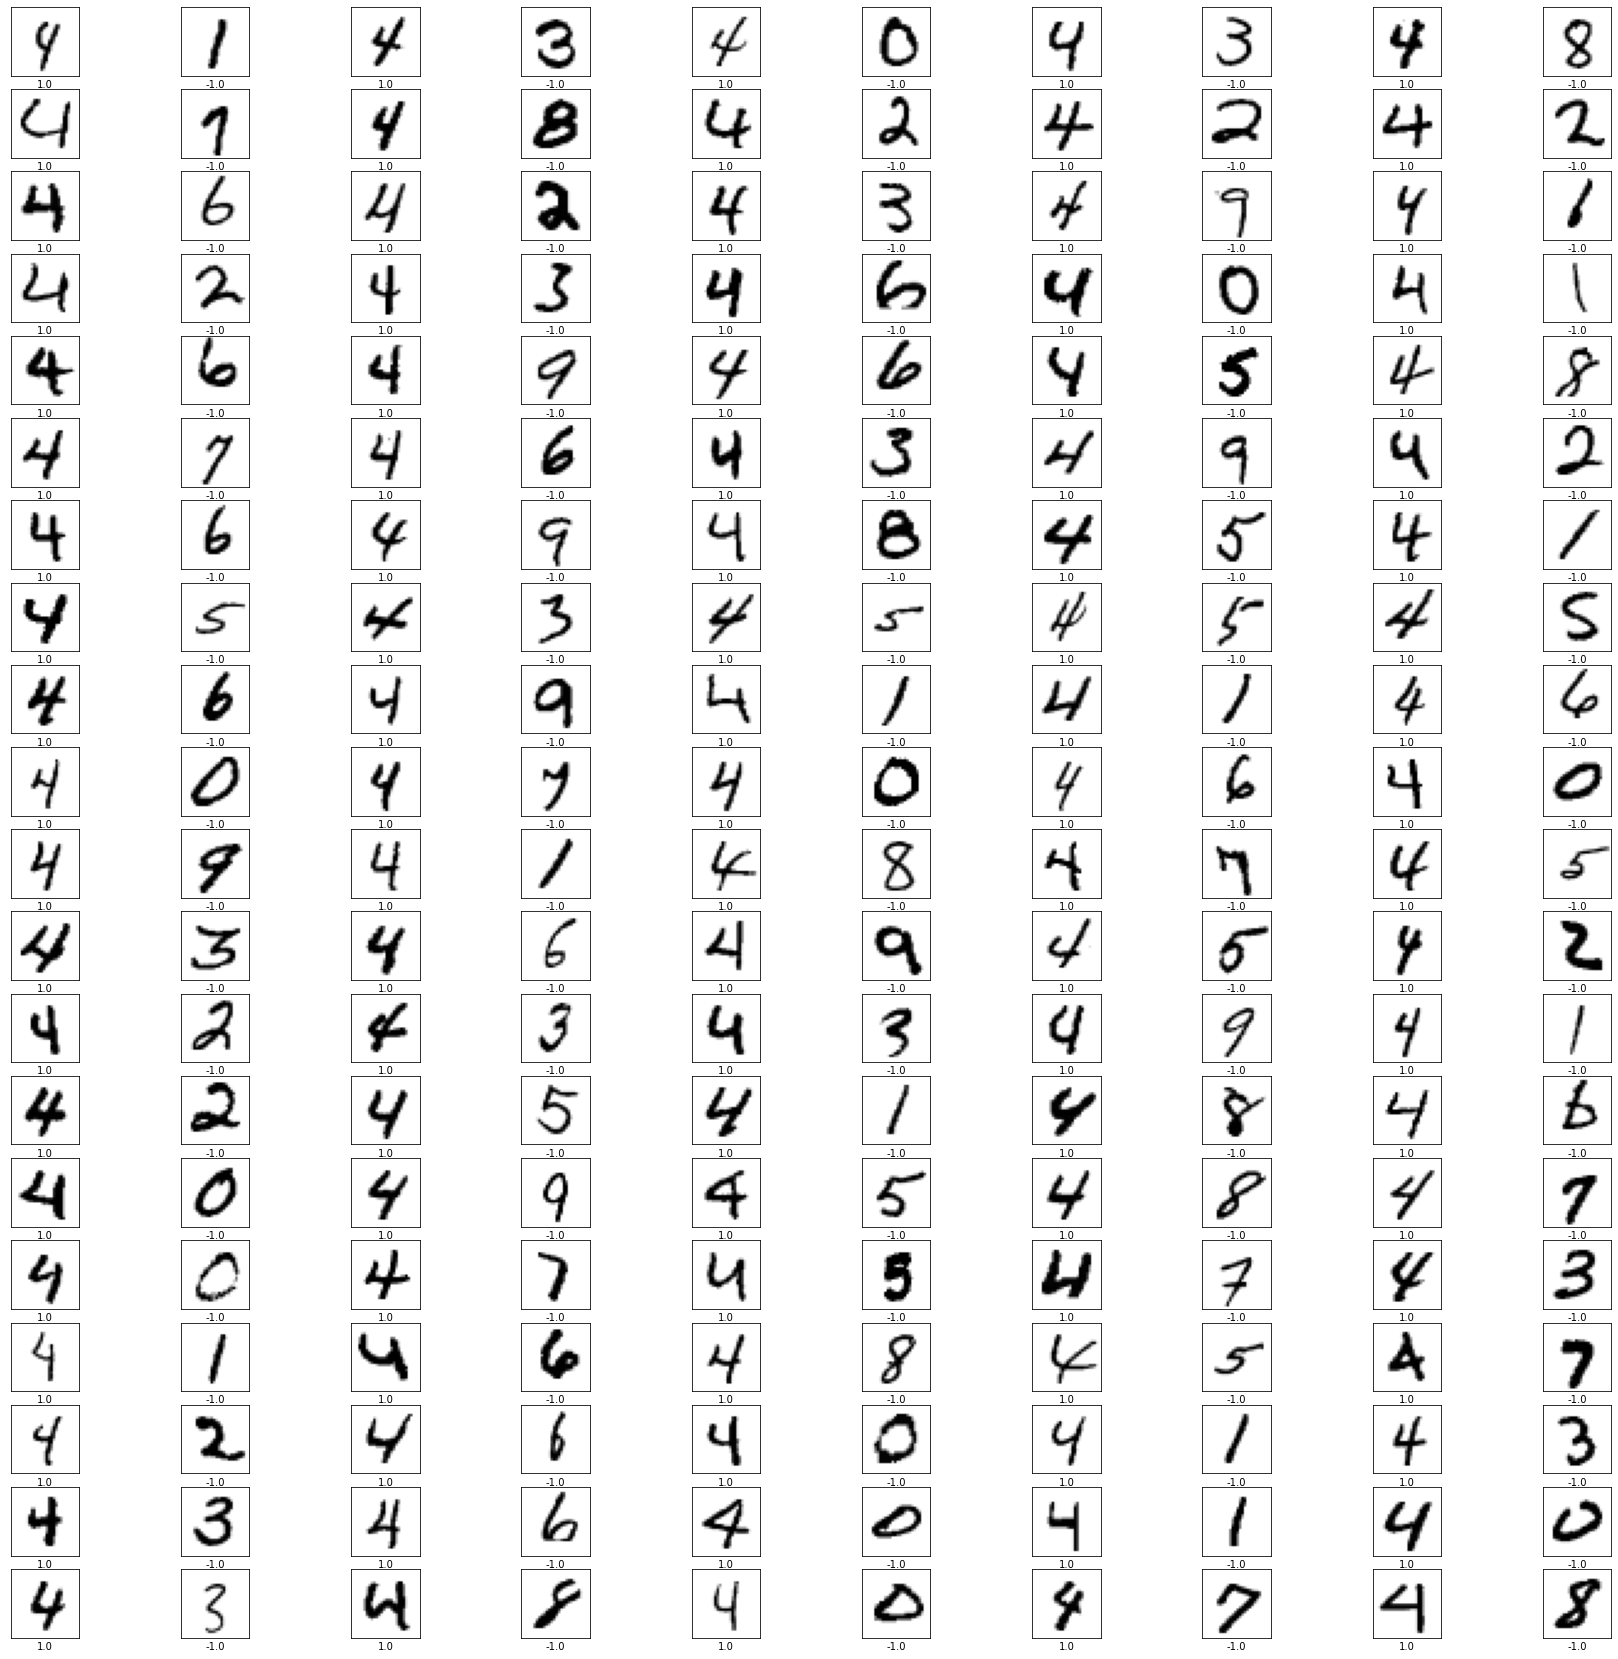

In [22]:
# display the first 200 training images with labels and verify that the data is in the correct formate.
plt.figure(figsize=(30, 30))# <--------------------------------------------------------------------------- UNKNOWN
for i in range(200):# i want to plot 25 images
    plt.subplot(20,10,i+1)# the letter "i" rappresent the position 
    plt.xticks([])# <------------------------------------------------------------------------------------ UNKNOWN
    plt.yticks([])
    plt.grid(False)# in this way i will not have the grid in on the images
    plt.imshow(np.reshape(BalancedArray[i], (28, 28)), cmap=plt.cm.binary)# load the image and make it show black and white
    plt.xlabel(BalancedLable[i])# add the lable associated to that image under it
plt.show()# show all the images

In [80]:
#                  Subdivision of the dataset (images and labels) between all the nodes

NodesInputDataList = []# list containing the vectorized images of each node
NodesLablesList = []# list containing the lables associated to images for each node

Elements = 10# Number of elemnets that each node will have
for i in range(NN):
    NodesLablesList.append(BalancedLable[Elements*i: Elements*(i+1)])#BalancedArray[]
    NodesInputDataList.append(BalancedArray[Elements*i: Elements*(i+1)])#BalancedLable[]


In [81]:
# i want to see if the data are distributed correctly
print("Lable list {}".format(np.shape(NodesLablesList)))
print(NodesLablesList[0][0])# you are accessing the first node at the first element of its proprietary lable dataset
print(NodesInputDataList[0][0])# you are accessing the first node at the first element of its proprietary vectorized images dataset
print("Nodes input data {}".format(np.shape(NodesInputDataList)))

Lable list (7, 10)
Nodes input data (7, 10, 784)


In [24]:
T = 3 # number of layers our neural network has
d = 784  # Number of neurons in each layer. Same numbers for all the layers

# Gradient Method Parameters
max_iters = 1000 # epochs
stepsize = 0.001 # learning rate

'''# QUESTA PARTE LA NASCONDO PERCHE DEVO SOSTITUIRLA CON QUELLA SOTTO
label_point = np.zeros(max_iters)
data_point = np.zeros([max_iters, 784])
# questa cosa non va bene, serve solo per il debugghing
for i in range(0, max_iters):
    label_point[i] = BalancedLable[i%200]
    data_point[i] = BalancedArray[i%200]
'''
    
###############################################################################
# Activation Function

DecisionVAriable = False
'''
def sigmoid_fn(xi):
    return 1/(1+np.exp(-xi))

# Derivative of Activation Function
def sigmoid_fn_derivative(xi):
    return sigmoid_fn(xi)*(1-sigmoid_fn(xi))
'''


def sigmoid_fn(xi):# tanh
    return (np.exp(xi) - np.exp(-xi)) / (np.exp(xi) + np.exp(-xi))

def sigmoid_fn_derivative(xi):# tanh_derivative
    return (2/(np.exp(xi)+np.exp(-xi)))**2


# Inference: x_tp = f(xt,ut)
def inference_dynamics(xt,ut):
    """
        input: 
              xt current state
              ut current input
        output: 
              xtp next state
    """
    xtp = np.zeros(d)
    for ell in range(d):
        temp = xt@ut[ell,1:] + ut[ell,0] # including the bias

        xtp[ell] = sigmoid_fn( temp ) # x' * u_ell
  
    return xtp

# Forward Propagation
def forward_pass(uu,x0):
    """
        input: 
              uu input trajectory: u[0],u[1],..., u[T-1]
              x0 initial condition
        output: 
              xx state trajectory: x[1],x[2],..., x[T]
    """
    xx = np.zeros((T,d))
    xx[0] = x0

    for t  in range(T-1):
        xx[t+1] = inference_dynamics(xx[t],uu[t]) # x^+ = f(x,u)

    return xx
  


# Adjoint dynamics: 
#   state:    lambda_t = A.T lambda_tp
#   output: deltau_t = B.T lambda_tp
def adjoint_dynamics(ltp,xt,ut):
    """
        input: 
              llambda_tp current costate
              xt current state
              ut current input
        output: 
              llambda_t next costate
              delta_ut loss gradient wrt u_t
    """
    df_dx = np.zeros((d,d))

    # df_du = np.zeros((d,(d+1)*d))
    Delta_ut = np.zeros((d,d+1))

    for j in range(d):
        dsigma_j = sigmoid_fn_derivative(xt@ut[j,1:] + ut[j,0]) 

        df_dx[:,j] = ut[j,1:]*dsigma_j
        # df_du[j, XX] = dsigma_j*np.hstack([1,xt])
    
        # B'@ltp
        Delta_ut[j,0] = ltp[j]*dsigma_j
        Delta_ut[j,1:] = xt*ltp[j]*dsigma_j
  
    lt = df_dx@ltp # A'@ltp
    # Delta_ut = df_du@ltp

    return lt, Delta_ut

# Backward Propagation
def backward_pass(xx,uu,llambdaT):
    """
        input: 
              xx state trajectory: x[1],x[2],..., x[T]
              uu input trajectory: u[0],u[1],..., u[T-1]
              llambdaT terminal condition
        output: 
              llambda costate trajectory
              delta_u costate output, i.e., the loss gradient
    """
    llambda = np.zeros((T,d))
    llambda[-1] = llambdaT

    Delta_u = np.zeros((T-1,d,d+1))

    for t in reversed(range(T-1)): # T-2,T-1,...,1,0
        llambda[t], Delta_u[t] = adjoint_dynamics(llambda[t+1],xx[t],uu[t])

    return Delta_u












###############################################################################
# MAIN (qua sotto bisogna effettuare le sostituzioni)
###############################################################################

# use those two lists
#NodesInputDataList = []# list containing the vectorized images of each node
#NodesLablesList = []# list containing the lables associated to images for each node

MAXITERS = np.int(1e3) # Explicit Casting
# [AgentNumber, Layer, Node, Iteration]
XX = np.zeros((NN,MAXITERS))# this tensor will contain the evolution of the states of our system
SS = np.zeros((NN,MAXITERS))# tensor containing the history of the gradients of the cost function

XX_init = 10*np.random.rand(NN)# inizialization of our initial conditions
XX[:,0] = XX_init# appending of initial conditions
XX_dg[:,0] = XX_init

for ii in range (NN):
    _, SS[ii,0] = quadratic_fn(XX[ii,0],Q[ii],R[ii])# here he assigne the initial value of the gradient of the cost function for each node

FF = np.zeros((MAXITERS))# vector containing the evolution of the cost
'''
J = np.zeros(max_iters)                       # Cost

# Initial Weights / Initial Input Trajectory
uu = -np.random.randn(T-1, d, d+1)# there is d+1 becouse we have bias in each node

# Initial State Trajectory.
xx = forward_pass(uu,data_point[0]) # T x d

# forcing the last layer of the weiths to be composed by zeros except for the first neuron 
for i in range(1, np.shape(uu)[1]):
    uu[np.shape(uu)[0]-1][i]=ZeroVector
print("Riassegnamento {0}".format(uu[np.shape(uu)[0]-1][0:3]))
'''










ss = 1e-2 # stepsize

for tt in range (MAXITERS-1):
    if (tt % 50) == 0:
        print("Iteration {:3d}".format(tt), end="\n")
    
    for ii in range (NN):
        Nii = np.nonzero(Adj[ii])[0]# extracting the indices of the inneighborhood of the node using the adjacency matrix(looks which values are not equal to zero in that row)
        
        XX[ii,tt+1] = WW[ii,ii]*XX[ii,tt] - ss*SS[ii,tt]# future state of node i is equal to its own weighted state minus the current avareged gradient
        for jj in Nii:
            XX[ii,tt+1] += WW[ii,jj]*XX[jj,tt]# for each node compute its future state adding to itself (state) the weighted average of the states of the neighborhoods

        f_ii, grad_fii = quadratic_fn(XX[ii,tt],Q[ii],R[ii])# compute the value of the cost function and its gradient 
        _, grad_fii_p = quadratic_fn(XX[ii,tt+1],Q[ii],R[ii])# compute the gradient of the cost function in the future state XX (used for the difference of gradients)
        SS[ii,tt+1] = WW[ii,ii]*SS[ii,tt] +(grad_fii_p-grad_fii)# future gradient of node i is equal to its own weighted gradient minus the difference between future gradient for this state minus the current gradient for this state
        for jj in Nii:
            SS[ii,tt+1] += WW[ii,jj]*SS[jj,tt]# for each node compute its future gradient adding the part calculated above and the weighted average of the gradients of the neighborhoods

        FF[tt] +=f_ii# updating the cost vector
'''
# GO!
for k in range(max_iters):
    #if k%4 == 0:
    print('Cost at k={:d} is {:.10f} lable: {}'.format(k,J[k-1], label_point[k]))
   
    # Initial State Trajectory
    xx = forward_pass(uu,data_point[k]) # T x d

    # Backward propagation
    llambdaT = 2*( xx[-1,:] - label_point[k]) # xT . LambdaT = 2*(-LablePoint)
    Delta_u = backward_pass(xx,uu,llambdaT) # the gradient of the loss function 
  
    # Update the weights
    uu = uu - stepsize*Delta_u # overwriting the old value

    """# parte suggerita dal prof dove vado a azzerare a ogni iterazione tutti i pesi dei neuroni tranne che il primo
    for i in range(1, np.shape(uu)[1]):
        uu[np.shape(uu)[0]-1][i]=ZeroVector

    print("Riassegnamento {0}".format(uu[np.shape(uu)[0]-1][0:3]))
    print("xx {0}".format(xx[np.shape(xx)[0]-1][0:3]))
    """
  
    # Forward propagation
    xx = forward_pass(uu,data_point[k])
  
    # Store the Loss Value across Iterations
    J[k] = (xx[-1,:] - label_point[k])@(xx[-1,:] - label_point[k]) # it is the cost at k+1
    # np.linalg.norm( xx[-1,:] - label_point )**2
'''

Riassegnamento [[-0.23564879  1.36405751  1.05780464 ... -0.44843606  1.56696908
   0.13334714]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Cost at k=0 is 0.0000000000 lable: 1.0
Cost at k=1 is 10.6710306376 lable: -1.0
Cost at k=2 is 33.0879310443 lable: 1.0
Cost at k=3 is 12.5300217117 lable: -1.0
Cost at k=4 is 10.4497703064 lable: 1.0
Cost at k=5 is 27.3339965170 lable: -1.0
Cost at k=6 is 18.2275552871 lable: 1.0
Cost at k=7 is 5.8980591940 lable: -1.0
Cost at k=8 is 15.1601089189 lable: 1.0
Cost at k=9 is 7.7368742196 lable: -1.0
Cost at k=10 is 10.2649329016 lable: 1.0
Cost at k=11 is 9.2803057982 lable: -1.0
Cost at k=12 is 8.8482389939 lable: 1.0
Cost at k=13 is 14.9627980446 lable: -1.0
Cost at k=14 is 12.2958812594 lable: 1.0
Cost at k=15 is 10.9646857454 lable: -1.0
Cost at k=16 is 15.3276626027 lable: 1.0
Cost at k=17 is 6.4439977587 lable: -1.0
Cost at k=18 is 6.80834456

Cost at k=193 is 5.8684522379 lable: -1.0
Cost at k=194 is 0.3859186117 lable: 1.0
Cost at k=195 is 9.1005841853 lable: -1.0
Cost at k=196 is 4.3318550448 lable: 1.0
Cost at k=197 is 0.1877729526 lable: -1.0
Cost at k=198 is 4.4029358163 lable: 1.0
Cost at k=199 is 0.3272135515 lable: -1.0
Cost at k=200 is 5.2231858844 lable: 1.0
Cost at k=201 is 1.3400584147 lable: -1.0
Cost at k=202 is 15.0246439381 lable: 1.0
Cost at k=203 is 0.0168277753 lable: -1.0
Cost at k=204 is 6.6756996704 lable: 1.0
Cost at k=205 is 0.0074467127 lable: -1.0
Cost at k=206 is 0.7686689378 lable: 1.0
Cost at k=207 is 0.0071060341 lable: -1.0
Cost at k=208 is 4.1221652903 lable: 1.0
Cost at k=209 is 0.0144920330 lable: -1.0
Cost at k=210 is 13.4597880769 lable: 1.0
Cost at k=211 is 20.9134861424 lable: -1.0
Cost at k=212 is 6.0927040841 lable: 1.0
Cost at k=213 is 0.0136742419 lable: -1.0
Cost at k=214 is 18.5443277674 lable: 1.0
Cost at k=215 is 3.8764812474 lable: -1.0
Cost at k=216 is 8.3128050962 lable: 1.0


Cost at k=390 is 9.2732313104 lable: 1.0
Cost at k=391 is 0.0626753153 lable: -1.0
Cost at k=392 is 20.8465628000 lable: 1.0
Cost at k=393 is 9.0693505521 lable: -1.0
Cost at k=394 is 0.0967384616 lable: 1.0
Cost at k=395 is 7.4484771598 lable: -1.0
Cost at k=396 is 4.2452260393 lable: 1.0
Cost at k=397 is 2.6165960323 lable: -1.0
Cost at k=398 is 0.3421528184 lable: 1.0
Cost at k=399 is 1.6814275541 lable: -1.0
Cost at k=400 is 0.5940412436 lable: 1.0
Cost at k=401 is 1.1454014227 lable: -1.0
Cost at k=402 is 3.8135151768 lable: 1.0
Cost at k=403 is 0.0255929458 lable: -1.0
Cost at k=404 is 4.1680492148 lable: 1.0
Cost at k=405 is 0.0148584310 lable: -1.0
Cost at k=406 is 0.0667024613 lable: 1.0
Cost at k=407 is 0.0112010415 lable: -1.0
Cost at k=408 is 4.0552074648 lable: 1.0
Cost at k=409 is 0.0288372344 lable: -1.0
Cost at k=410 is 9.6940932554 lable: 1.0
Cost at k=411 is 15.0781038419 lable: -1.0
Cost at k=412 is 6.1627859044 lable: 1.0
Cost at k=413 is 0.0079103268 lable: -1.0
Co

Cost at k=587 is 0.8225050179 lable: -1.0
Cost at k=588 is 0.2759475738 lable: 1.0
Cost at k=589 is 0.1862255844 lable: -1.0
Cost at k=590 is 5.1259838538 lable: 1.0
Cost at k=591 is 0.1798253954 lable: -1.0
Cost at k=592 is 9.5349875396 lable: 1.0
Cost at k=593 is 13.2514772558 lable: -1.0
Cost at k=594 is 0.0172787914 lable: 1.0
Cost at k=595 is 11.5204547748 lable: -1.0
Cost at k=596 is 4.0392717504 lable: 1.0
Cost at k=597 is 8.4361598958 lable: -1.0
Cost at k=598 is 0.0761195820 lable: 1.0
Cost at k=599 is 3.9917689037 lable: -1.0
Cost at k=600 is 0.1064853990 lable: 1.0
Cost at k=601 is 2.7874957140 lable: -1.0
Cost at k=602 is 0.7520530152 lable: 1.0
Cost at k=603 is 0.0560627906 lable: -1.0
Cost at k=604 is 4.0348294638 lable: 1.0
Cost at k=605 is 0.0230032126 lable: -1.0
Cost at k=606 is 0.0237799945 lable: 1.0
Cost at k=607 is 0.0180204027 lable: -1.0
Cost at k=608 is 4.0122712110 lable: 1.0
Cost at k=609 is 0.0635976900 lable: -1.0
Cost at k=610 is 5.3916503261 lable: 1.0
Co

Cost at k=784 is 0.1267234426 lable: 1.0
Cost at k=785 is 14.9737235845 lable: -1.0
Cost at k=786 is 4.3535096153 lable: 1.0
Cost at k=787 is 1.0199626831 lable: -1.0
Cost at k=788 is 0.1274079035 lable: 1.0
Cost at k=789 is 0.2061917859 lable: -1.0
Cost at k=790 is 4.7330146895 lable: 1.0
Cost at k=791 is 0.1882369104 lable: -1.0
Cost at k=792 is 7.5679001757 lable: 1.0
Cost at k=793 is 12.1929752185 lable: -1.0
Cost at k=794 is 0.0083473012 lable: 1.0
Cost at k=795 is 11.5116316986 lable: -1.0
Cost at k=796 is 4.0219934371 lable: 1.0
Cost at k=797 is 10.7448497294 lable: -1.0
Cost at k=798 is 0.0379698735 lable: 1.0
Cost at k=799 is 4.2688590326 lable: -1.0
Cost at k=800 is 0.0510144768 lable: 1.0
Cost at k=801 is 3.4633592519 lable: -1.0
Cost at k=802 is 0.3629424960 lable: 1.0
Cost at k=803 is 0.0666262745 lable: -1.0
Cost at k=804 is 4.0172974916 lable: 1.0
Cost at k=805 is 0.0243482355 lable: -1.0
Cost at k=806 is 0.0148998533 lable: 1.0
Cost at k=807 is 0.0187658302 lable: -1.0


Cost at k=982 is 4.0610862934 lable: 1.0
Cost at k=983 is 8.6095473445 lable: -1.0
Cost at k=984 is 0.1034582288 lable: 1.0
Cost at k=985 is 11.2599841177 lable: -1.0
Cost at k=986 is 4.2881368179 lable: 1.0
Cost at k=987 is 0.9047896478 lable: -1.0
Cost at k=988 is 0.0840174124 lable: 1.0
Cost at k=989 is 0.1673960520 lable: -1.0
Cost at k=990 is 4.6282376976 lable: 1.0
Cost at k=991 is 0.1536306163 lable: -1.0
Cost at k=992 is 6.9178989466 lable: 1.0
Cost at k=993 is 9.4473577128 lable: -1.0
Cost at k=994 is 0.0056615911 lable: 1.0
Cost at k=995 is 10.2475164017 lable: -1.0
Cost at k=996 is 4.0165215059 lable: 1.0
Cost at k=997 is 10.2421823289 lable: -1.0
Cost at k=998 is 0.0280632509 lable: 1.0
Cost at k=999 is 3.6443168136 lable: -1.0


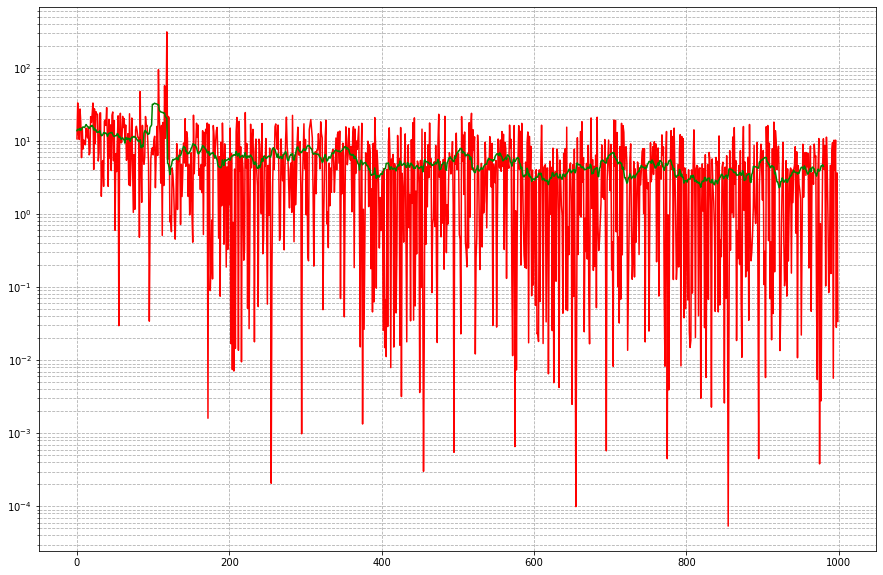

In [25]:
#                                    test on training data

NumberOfElements = 20
AverageCost = moving_average(J, n=NumberOfElements)# here i compute the moving average of the cost vector J
AAAA = np.ones(NumberOfElements)

#_,ax = plt.subplots()
plt.rcParams['figure.figsize'] = [15, 10]# in this way you set the size of the plot
plt.plot(range(max_iters), J, color='r', label='J')
plt.plot(range(len(AverageCost)), AverageCost, color='g', label='avg(J)')
#plt.grid()
plt.grid(True,which="both", linestyle='--')
plt.yscale("log")
plt.show()

Shape of the solutions propagationa (3, 784)
label_point :-1
NN concensus mean: -0.9969945878905956
NN concensus First: -0.9999999999984581


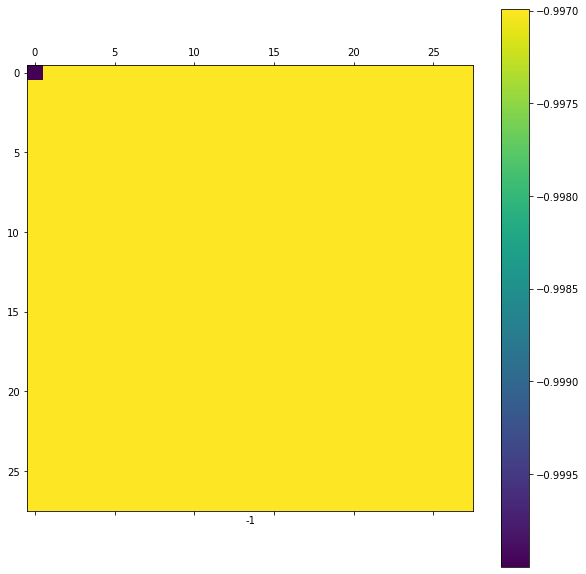

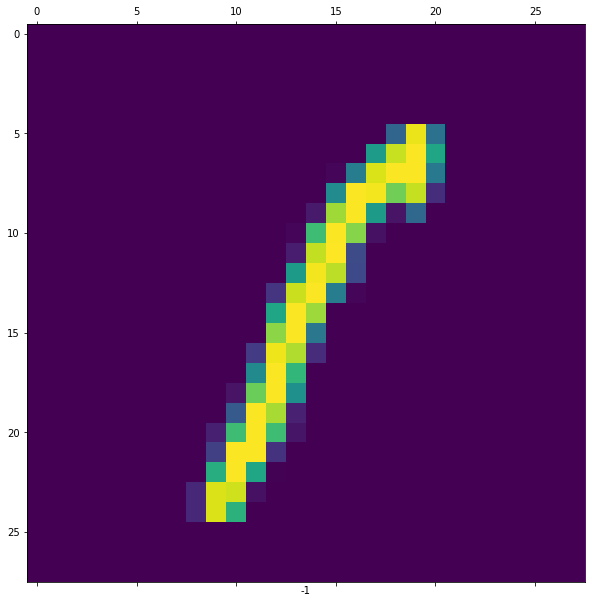

In [26]:
#                                    test on test data 

mm = 34
xx = forward_pass(uu, SrecchedDatasetX[mm])
print("Shape of the solutions propagationa {0}".format(np.shape(xx)))
#print("Predicted solution {0}".format(xx[-1][:]))
print("label_point :{0}".format(y_train[mm]))
print("NN concensus mean: {0}".format(np.mean(xx[-1][:])))
print("NN concensus First: {0}".format(np.mean(xx[-1][0])))

prova = np.reshape(xx[-1], (28, 28))# here at index you can put whatewer number you wish to see if the conversion went correctly
plt.matshow(prova)
plt.colorbar()# i want to have the gradueted bar with colors
plt.grid(False)# i dont want to have a grid on the image
plt.xlabel(y_train[mm])# write the number on the photo on x axis
plt.show()

# HERE I TEST THE CONVERSION GOING BACKWARD (CHEKING IF THE IMAGE IS CORRECT)
#print(SrecchedDatasetX[1])
prova = np.reshape(SrecchedDatasetX[mm], (28, 28))# here at index you can put whatewer number you wish to see if the conversion went correctly
plt.matshow(prova)
plt.xlabel(y_train[mm])
plt.show()

In [27]:
#np.shape(ZeroVector)
#np.shape(xx)
#np.shape(uu)

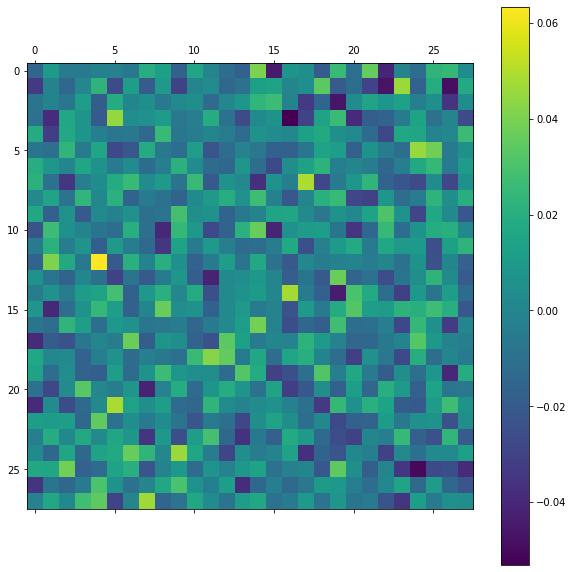

In [28]:
#                      check of the last layer of uu (weiths)

AAAA = uu[-1][2][1:785]
prova = np.reshape(AAAA, (28, 28))# here at index you can put whatewer number you wish to see if the conversion went correctly
plt.matshow(prova)
plt.colorbar()
plt.grid(False)
plt.show()

Shape of the solutions propagationa (3, 784)
label_point :1.0
NN concensus: 0.9303296665330856


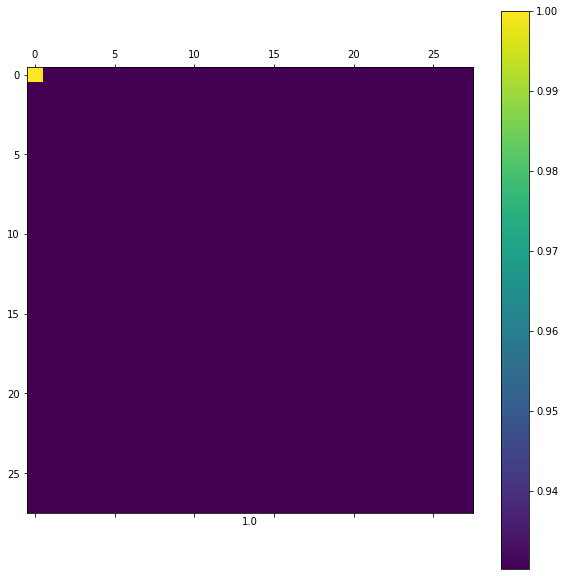

In [29]:
#                      I wanto to see the output of the NN and the lables

mm = 0
xx = forward_pass(uu,data_point[mm])
print("Shape of the solutions propagationa {0}".format(np.shape(xx)))
#print("Predicted solution {0}".format(xx[-1][:]))
print("label_point :{0}".format(label_point[mm]))
print("NN concensus: {0}".format(np.mean(xx[-1][:])))

prova = np.reshape(xx[-1], (28, 28))# here at index you can put whatewer number you wish to see if the conversion went correctly
plt.matshow(prova)
plt.colorbar()# i want to have the gradueted bar with colors
plt.grid(False)# i dont want to have a grid on the image
plt.xlabel(label_point[mm])# write the number on the photo on x axis
plt.show()

In [30]:
#                               saving the weights of uu and the values of J (cost vector)

'''
print(np.shape(uu))
data = np.asarray([np.reshape(uu, np.shape(uu)[0]*784*785)])
print(np.shape(data))
data2 = np.asarray([np.reshape(uu, [np.shape(uu)[0], 784, 785])])
print(uu-data2)
np.savetxt('uu_matrix0p45.csv', data, delimiter=':')

data10 = np.asarray([J])
np.savetxt('J_vector0p45.csv', data10, delimiter=':')
'''

"\nprint(np.shape(uu))\ndata = np.asarray([np.reshape(uu, np.shape(uu)[0]*784*785)])\nprint(np.shape(data))\ndata2 = np.asarray([np.reshape(uu, [np.shape(uu)[0], 784, 785])])\nprint(uu-data2)\nnp.savetxt('uu_matrix0p45.csv', data, delimiter=':')\n\ndata10 = np.asarray([J])\nnp.savetxt('J_vector0p45.csv', data10, delimiter=':')\n"

In [31]:
#                                loading the weights of uu and the values of J (cost vector)

#prova = np.loadtxt(fname = 'J_vector.csv', delimiter=':')
#print(np.shape(prova))

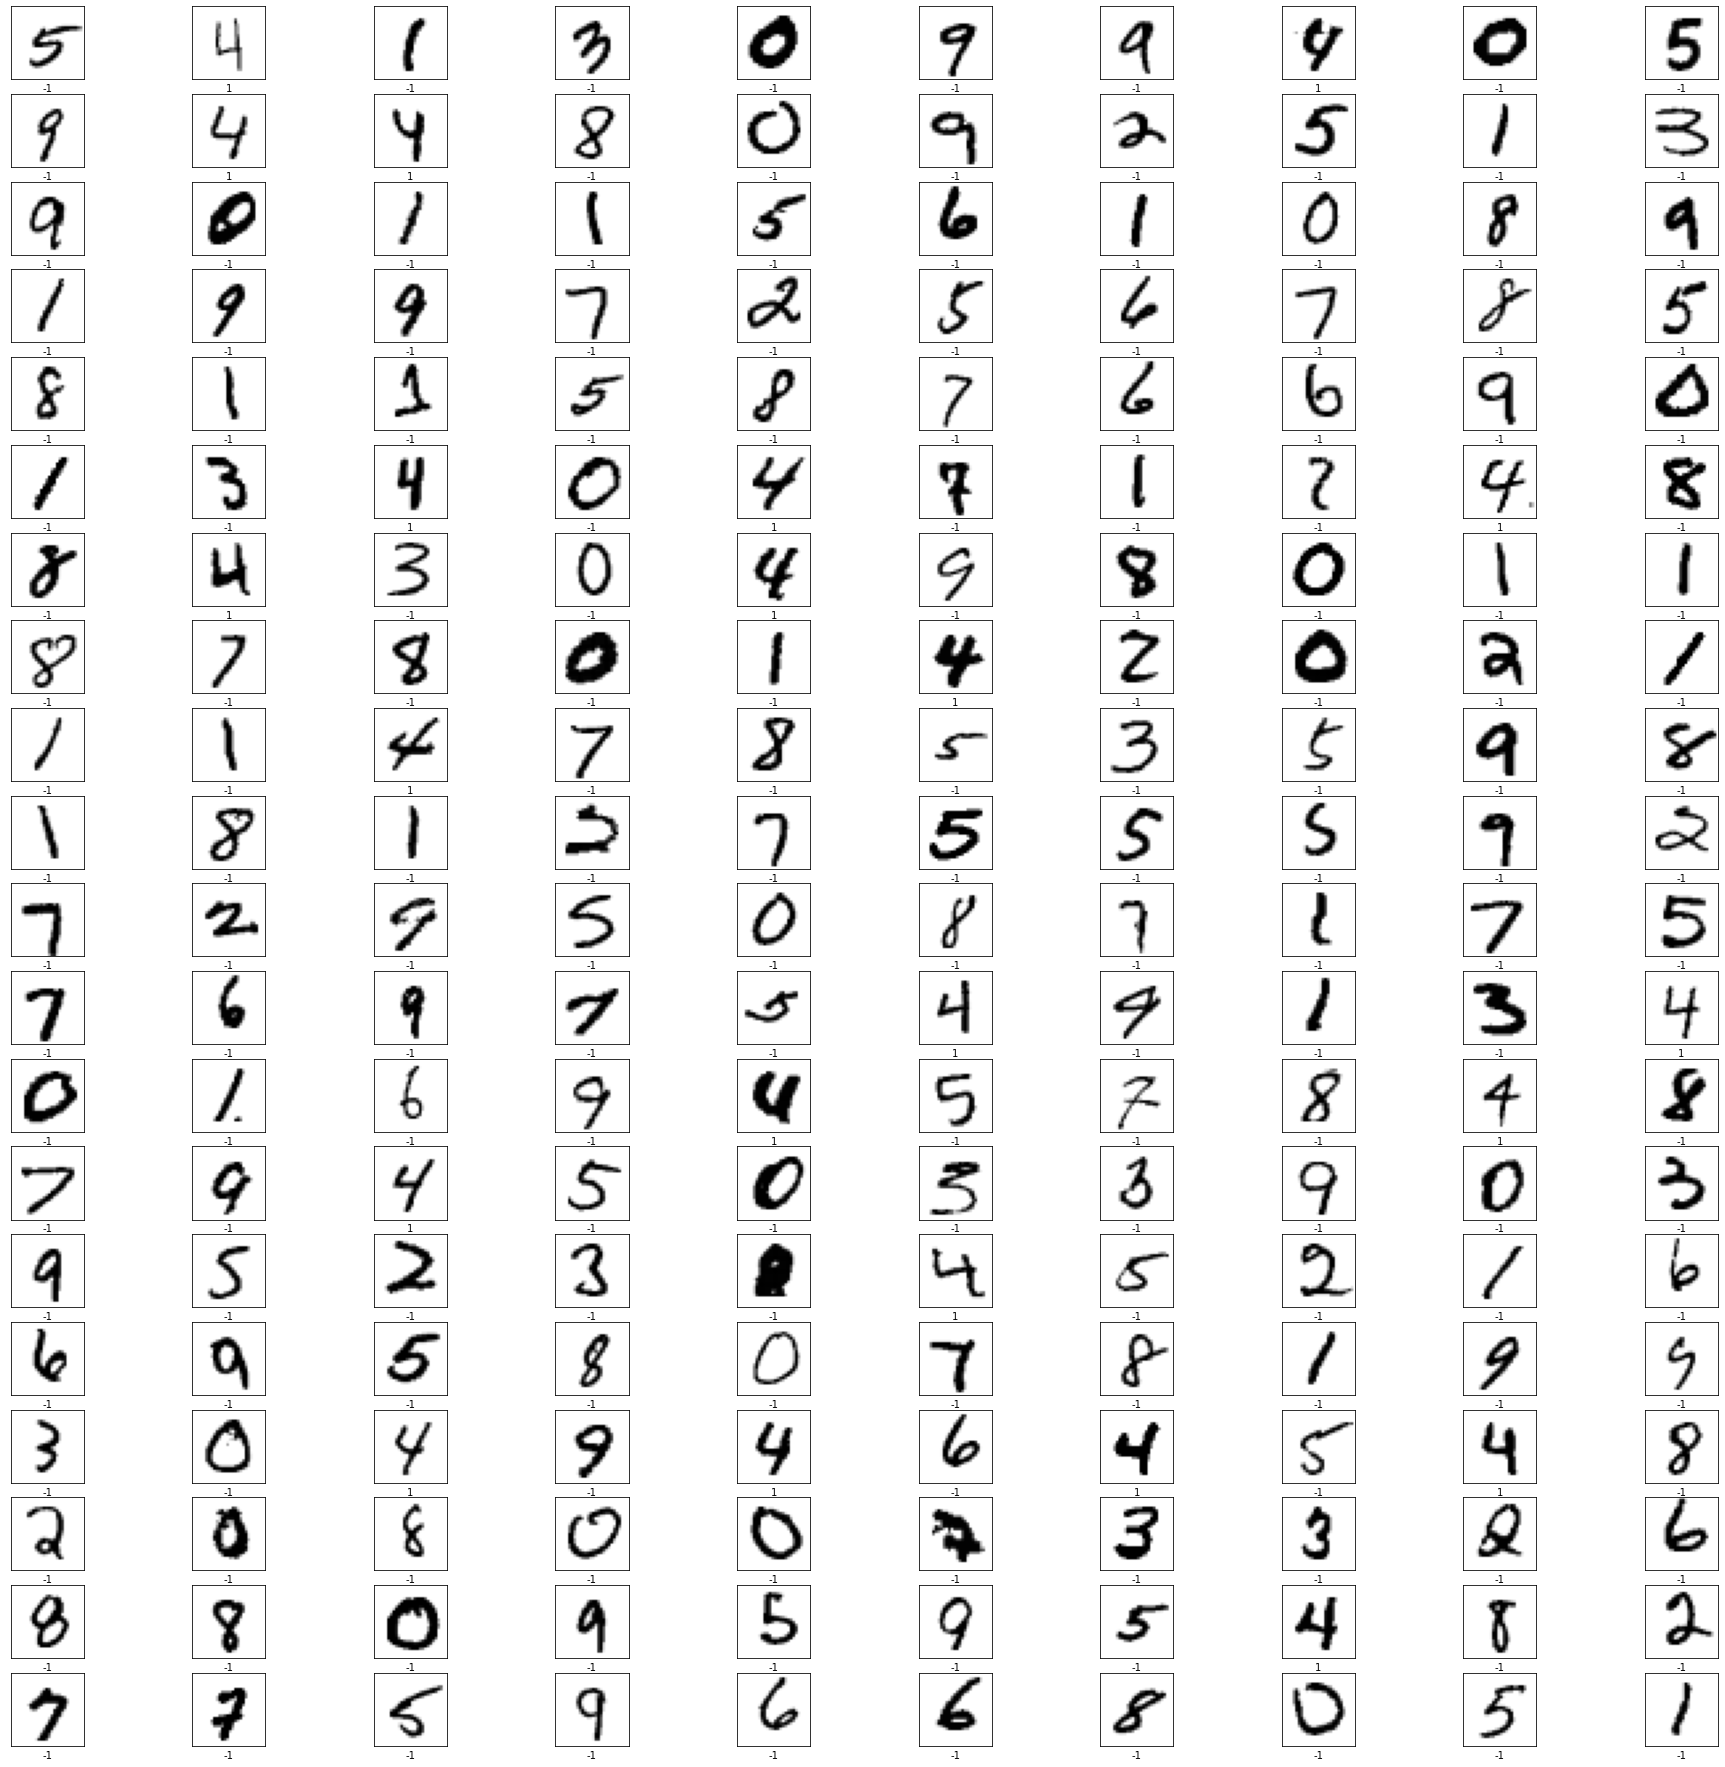

In [32]:
# HERE I RESHAPE THE IMAGES FROM A MATRIX TO A VECTOR MANTAINING THE DATA CONTENT (for validation data)

StrecchedValidationDataset = np.reshape(x_test, (np.shape(x_test)[0], 784))
# this vector contains linearized images for validation of the neural network
# "y_test" contains the lables of the test set

# display the first 25 training images with labels and verify that the data is in the correct formate.
plt.figure(figsize=(32,32))# <--------------------------------------------------------------------------- UNKNOWN
for i in range(200):# i want to plot 25 images
    plt.subplot(20,10,i+1)# the letter "i" rappresent the position 
    plt.xticks([])# <------------------------------------------------------------------------------------ UNKNOWN
    plt.yticks([])
    plt.grid(False)# in this way i will not have the grid in on the images
    plt.imshow(np.reshape(StrecchedValidationDataset[i], (28, 28)), cmap=plt.cm.binary)# load the image and make it show black and white
    plt.xlabel(y_test[i])# add the lable associated to that image under it
plt.show()# show all the images

In [33]:
#                                         Validation function

def ValidationFunction(uu: np.array, VectoryzedImagesTestArray: np.array, LablesTestArray: np.array, NumberOfEvaluations = 100, fringe = 0.5):
    """    1 -> the prediction is correct
           0 -> the prediction is wrong
    """
    VectorOfEstimation = -np.ones(NumberOfEvaluations)
    for i in range(NumberOfEvaluations):
        xx = forward_pass(uu, VectoryzedImagesTestArray[i])# here i move forward the image in the neural network
        #prediction = np.mean(xx[-1][:])# here i compute the avarege of the resoults of neural network
        prediction = xx[-1][0]
        
        if (prediction >= fringe) and (LablesTestArray[i] == 1):
            VectorOfEstimation[i] = 1
        if ((prediction >= fringe) and (LablesTestArray[i] == -1)) or (prediction < fringe) and (LablesTestArray[i] == 1):
            VectorOfEstimation[i] = 0

        if (prediction <= -fringe) and (LablesTestArray[i] == -1):
            VectorOfEstimation[i] = 1
        if ((prediction <= -fringe) and (LablesTestArray[i] == 1)) or (prediction > -fringe) and (LablesTestArray[i] == -1):
            VectorOfEstimation[i] = 0
    unique, counts = np.unique(VectorOfEstimation, return_counts=True)
    Resoult = dict(zip(unique, counts))
    return Resoult

In [34]:
samples = 2000
treshold = 0.8
Dictionary = ValidationFunction(uu, StrecchedValidationDataset, y_test, samples, treshold)
print(Dictionary)
print("The accuracy is {}".format(Dictionary[1.0]/samples))

{0.0: 1158, 1.0: 842}
The accuracy is 0.421


In [35]:
# toglimi ?

mm = 93
xx = forward_pass(uu, StrecchedValidationDataset[mm])# here i move forward the image in the neural network
prediction = xx[-1][0]
print("\nThe prediction is {} while the lable is {}".format(prediction, y_test[mm]))


The prediction is -0.9025973369090996 while the lable is -1


In [36]:
# https://towardsdatascience.com/what-to-do-when-your-classification-dataset-is-imbalanced-6af031b12a36
# https://stackoverflow.com/questions/39561560/getting-gradient-of-model-output-w-r-t-weights-using-keras
# https://realpython.com/python-exceptions/
# https://math.stackexchange.com/questions/2503428/derivative-of-binary-cross-entropy-why-are-my-signs-not-right